# Flight Delay prediction using Spark

![Drawing of a plane](<plane.png>)

In this notebook we will develop a machine learning model to predict arrival delays of commercial flights using US domestic flight data. The project aims to create an accurate prediction model using only information available at the time of takeoff.

Our workflow consists of several key steps:

**1. Data Loading and Exploration**
- Loading the US Department of Transportation flight data
- Initial analysis of available variables
- Filtering out forbidden variables that wouldn't be available at takeoff time

**2. Data Processing and Feature Engineering**
- Transforming variables into appropriate formats
- Creating derived features to improve model performance
- Handling categorical and numerical data appropriately

**3. Model Development**
- Selecting and implementing appropriate machine learning algorithms
- Training the model using Spark MLlib
- Performing hyperparameter tuning and optimization

**4. Model Validation**
- Implementing validation strategies to assess model performance
- Measuring prediction accuracy using appropriate metrics
- Documenting validation results

**5. Model Storage**
- Saving the best performing model for future use
- Ensuring compatibility with our separate testing application

The final result will be a trained model capable of predicting flight arrival delays, which will be stored and later used by a separate Spark application for testing on unseen data. Our focus is on effectively utilizing Spark's distributed computing capabilities while building a practical solution for this real-world prediction problem.
## Data Loading
First we load the example data that will be used to perform the exploratory analysis of the data and later used to find the optimal model for the aplication. 

The first step after loading the data is to drop all the variables that can't be used in the aplication, as they are information that is only known after the flight happens. 


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import bz2

spark = SparkSession.builder \
    .appName("Decompress and Process CSV with Spark") \
    .getOrCreate()


def decompress_bz2_to_csv(bz2_file_path, csv_file_path):
    # Descomprimir el archivo BZ2 y guardar como CSV temporal
    with bz2.open(bz2_file_path, 'rb') as f_in:
        with open(csv_file_path, 'wb') as f_out:
            f_out.write(f_in.read())

bz2_file_path = 'data/1993.csv.bz2'
csv_file_path = 'data/1993.csv'

decompress_bz2_to_csv(bz2_file_path, csv_file_path)

df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

columns_to_drop = [
    'ArrTime', 
    'ActualElapsedTime', 
    'AirTime', 
    'TaxiIn', 
    'Diverted', 
    'CarrierDelay', 
    'WeatherDelay', 
    'NASDelay', 
    'SecurityDelay', 
    'LateAircraftDelay'
]

df = df.drop(*columns_to_drop)

# Mostrar las primeras filas
df.show(5)



,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiOut,Cancelled,CancellationCode
0,1993,1,29,5,1055.0,1055,1212,US,66,NaN,77,16.0,0.0,EWR,BUF,282.0,NaN,0,NaN
1,1993,1,30,6,1052.0,1055,1212,US,66,NaN,77,2.0,-3.0,EWR,BUF,282.0,NaN,0,NaN
2,1993,1,31,7,1103.0,1055,1212,US,66,NaN,77,1.0,8.0,EWR,BUF,282.0,NaN,0,NaN
3,1993,1,1,5,1738.0,1730,1941,US,68,NaN,131,8.0,8.0,MCO,PIT,834.0,NaN,0,NaN
4,1993,1,3,7,1737.0,1730,1941,US,68,NaN,131,5.0,7.0,MCO,PIT,834.0,NaN,0,NaN


## Data Cleaning
As we are using for the analysis the data of only one year the column for year can also be dropped. All observations where the flight was cancelled can be also eliminated, as we don't want to generate a model to clasify between cancelled and not. 

In [2]:
from pyspark.sql.functions import col

df = df.drop('Year')
df = df.filter(col('Cancelled') != 1)

df = df.drop('Cancelled')
df.show(5)


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiOut,CancellationCode
0,1,29,5,1055.0,1055,1212,US,66,NaN,77,16.0,0.0,EWR,BUF,282.0,NaN,NaN
1,1,30,6,1052.0,1055,1212,US,66,NaN,77,2.0,-3.0,EWR,BUF,282.0,NaN,NaN
2,1,31,7,1103.0,1055,1212,US,66,NaN,77,1.0,8.0,EWR,BUF,282.0,NaN,NaN
3,1,1,5,1738.0,1730,1941,US,68,NaN,131,8.0,8.0,MCO,PIT,834.0,NaN,NaN
4,1,3,7,1737.0,1730,1941,US,68,NaN,131,5.0,7.0,MCO,PIT,834.0,NaN,NaN


### Missing values handling

In [3]:
from pyspark.sql.functions import col, isnan, when, count

nan_percentage = (
    df.select(
        [(count(when(col(c).isNull() | isnan(col(c)), c)) / count("*") * 100).alias(c) for c in df.columns]
    )
)

nan_percentage.show()


Month                 0.000000
DayofMonth            0.000000
DayOfWeek             0.000000
DepTime               0.000000
CRSDepTime            0.000000
CRSArrTime            0.000000
UniqueCarrier         0.000000
FlightNum             0.000000
TailNum             100.000000
CRSElapsedTime        0.000000
ArrDelay              0.206221
DepDelay              0.000000
Origin                0.000000
Dest                  0.000000
Distance              0.135591
TaxiOut             100.000000
CancellationCode    100.000000
dtype: float64


Three variables **TailNum**, **TaxiOut** and **CancellationCode** don't have any values so we drop that columns too


In [4]:
df = df.drop('TailNum', 'TaxiOut', 'CancellationCode')
df.show(5)


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance
0,1,29,5,1055.0,1055,1212,US,66,77,16.0,0.0,EWR,BUF,282.0
1,1,30,6,1052.0,1055,1212,US,66,77,2.0,-3.0,EWR,BUF,282.0
2,1,31,7,1103.0,1055,1212,US,66,77,1.0,8.0,EWR,BUF,282.0
3,1,1,5,1738.0,1730,1941,US,68,131,8.0,8.0,MCO,PIT,834.0
4,1,3,7,1737.0,1730,1941,US,68,131,5.0,7.0,MCO,PIT,834.0


The other variables with `NaN` values need to be studied independently.



#### Distance
The handling of **Distance** is the easiest, as **Origin** and **Destination** have no missing values. The first step is to fill in the missing **Distance** values by using the value from another observation with the same **Origin** and **Destination**.

First, we identify all the **Origin-Destination** pairs with missing **Distance** values.


In [5]:
nan_distance_data = df.filter(col('Distance').isNull())
nan_distance_data.select('Origin', 'Dest').distinct().show()

Origin: SIT, Destination: KTN
Origin: MAF, Destination: DFW
Origin: LAX, Destination: MAF
Origin: MAF, Destination: ELP
Origin: KTN, Destination: WRG
Origin: MAF, Destination: AUS
Origin: JNU, Destination: KTN
Origin: DFW, Destination: MAF
Origin: ELP, Destination: MAF
Origin: HOU, Destination: MAF
Origin: ABQ, Destination: MAF
Origin: WRG, Destination: KTN
Origin: IAH, Destination: MAF
Origin: KTN, Destination: SEA
Origin: KTN, Destination: SIT
Origin: MAF, Destination: ABQ
Origin: DAL, Destination: MAF
Origin: MAF, Destination: IAH
Origin: SEA, Destination: KTN
Origin: MAF, Destination: HOU
Origin: MAF, Destination: DAL
Origin: AUS, Destination: MAF
Origin: KTN, Destination: JNU


In [6]:
df.filter(col("Distance").isNull()).show()


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance
91501,1,2,6,600.0,600,1040,WN,842,160,21.0,0.0,LAX,MAF,NaN
93049,1,2,6,600.0,600,1040,WN,904,160,25.0,0.0,LAX,MAF,NaN


After correcting most of the missing values, we find that there are no observations with **Origin** `'LAX'` and **Destination** `'MAF'`. We then try to study if there are any observations with **Origin** `'MAF'` and **Destination** `'LAX'`.


In [7]:
df.filter((col('Origin') == 'MAF') & (col('Dest') == 'LAX')).show()


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance


As there are no observations that can be used, we drop the two observations. However, this information could be retrieved from another source, but coming only from two observations is not worthy for the prediction.


In [8]:
df = df.filter(~((col('Origin') == 'LAX') & (col('Dest') == 'MAF')))



#### ArrDelay
Since Arrival Delay is the target variable we want to study, any technique used to impute a value would interfere with the future predictions of the model. Therefore, we directly eliminate the observations where **ArrDelay** is `NaN`.


In [9]:
df = df.filter(col('ArrDelay').isNotNull())

Month             0.0
DayofMonth        0.0
DayOfWeek         0.0
DepTime           0.0
CRSDepTime        0.0
CRSArrTime        0.0
UniqueCarrier     0.0
FlightNum         0.0
CRSElapsedTime    0.0
ArrDelay          0.0
DepDelay          0.0
Origin            0.0
Dest              0.0
Distance          0.0
dtype: float64


After eliminating these observations, the other variables that had missing values no longer have any.

### Format Transformations
Some of the variables have formats that are not optimal for model creation. Hours are represented as decimal numbers and need to be transformed. 

In [10]:
from pyspark.sql import functions as F

def convert_to_time_without_dates(df, column):
    # Extraer horas (dividir por 100, luego aplicar floor para la división entera)
    hours = (F.floor(df[column] / 100)).cast('int')

    minutes_and_seconds = df[column] % 100
    minutes = (F.floor(minutes_and_seconds / 1)).cast('int')
    seconds = ((minutes_and_seconds - minutes) * 100).cast('int')

    hours = hours % 24
    minutes = minutes % 60
    seconds = seconds % 60

    mask_24 = hours == 24
    hours = F.when(mask_24, 0).otherwise(hours)

    mask_60 = minutes == 60
    minutes = F.when(mask_60, 0).otherwise(minutes)
    hours = F.when(mask_60, hours + 1).otherwise(hours)

    hours = hours % 24
    minutes = minutes % 60
    seconds = seconds % 60

    time_str = F.concat(
        F.lpad(hours.cast('string'), 2, '0'),
        F.lit(':'),
        F.lpad(minutes.cast('string'), 2, '0'),
        F.lit(':'),
        F.lpad(seconds.cast('string'), 2, '0')
    )

    return time_str

# Aplicar la función a las columnas deseadas
df = df.withColumn('DepTime', convert_to_time_without_dates(df, 'DepTime'))
df = df.withColumn('CRSDepTime', convert_to_time_without_dates(df, 'CRSDepTime'))
df = df.withColumn('CRSArrTime', convert_to_time_without_dates(df, 'CRSArrTime'))

df.select('DepTime', 'CRSDepTime', 'CRSArrTime').show(5)


    DepTime CRSDepTime CRSArrTime
0  10:55:00   10:55:00   12:12:00
1  10:52:00   10:55:00   12:12:00
2  11:03:00   10:55:00   12:12:00
3  17:38:00   17:30:00   19:41:00
4  17:37:00   17:30:00   19:41:00


In [11]:
from pyspark.sql import functions as F

df = df.withColumn('DepTime', F.to_timestamp('DepTime', 'HH:mm:ss').cast('string').substr(12, 8))
df = df.withColumn('CRSDepTime', F.to_timestamp('CRSDepTime', 'HH:mm:ss').cast('string').substr(12, 8))
df = df.withColumn('CRSArrTime', F.to_timestamp('CRSArrTime', 'HH:mm:ss').cast('string').substr(12, 8))



In [12]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance
0,1,29,5,10:55:00,10:55:00,12:12:00,US,66,77,16.0,0.0,EWR,BUF,282.0
1,1,30,6,10:52:00,10:55:00,12:12:00,US,66,77,2.0,-3.0,EWR,BUF,282.0
2,1,31,7,11:03:00,10:55:00,12:12:00,US,66,77,1.0,8.0,EWR,BUF,282.0
3,1,1,5,17:38:00,17:30:00,19:41:00,US,68,131,8.0,8.0,MCO,PIT,834.0
4,1,3,7,17:37:00,17:30:00,19:41:00,US,68,131,5.0,7.0,MCO,PIT,834.0




### Types Downcasting
To improve the performance of the models, we can downcast some variables from very precise data types to simpler ones.


In [13]:
df.printSchema()

Month               int64
DayofMonth          int64
DayOfWeek           int64
DepTime            object
CRSDepTime         object
CRSArrTime         object
UniqueCarrier      object
FlightNum           int64
CRSElapsedTime      int64
ArrDelay          float64
DepDelay          float64
Origin             object
Dest               object
Distance          float64
dtype: object


As `short type` ranges from -32,768 to 32,767 and `float` ranges from approximately ±3.4 × 10⁻³⁸ to ±3.4 × 10³, with 7 decimal precision, we can downcast the varaibles to fit this.

As `int16` ranges from -32,768 to 32,767 and `float16` ranges from approximately ±6.55 × 10⁻⁵ to ± 65504, we can downcast the rest of the variables to them.


In [15]:
from pyspark.sql import functions as F
from pyspark.sql.types import ShortType, FloatType, TimestampType

df = df.withColumn("Month", F.col("Month").cast(ShortType()))
df = df.withColumn("DayofMonth", F.col("DayofMonth").cast(ShortType()))
df = df.withColumn("DayOfWeek", F.col("DayOfWeek").cast(ShortType()))
df = df.withColumn("FlightNum", F.col("FlightNum").cast(ShortType()))
df = df.withColumn("CRSElapsedTime", F.col("CRSElapsedTime").cast(ShortType()))
df = df.withColumn("ArrDelay", F.col("ArrDelay").cast(FloatType()))
df = df.withColumn("DepDelay", F.col("DepDelay").cast(FloatType()))
df = df.withColumn("Distance", F.col("Distance").cast(FloatType()))
df = df.withColumn("DepTime", F.to_timestamp("DepTime", "HH:mm:ss"))
df = df.withColumn("CRSDepTime", F.to_timestamp("CRSDepTime", "HH:mm:ss"))
df = df.withColumn("CRSArrTime", F.to_timestamp("CRSArrTime", "HH:mm:ss"))
df.printSchema()


Month                int8
DayofMonth           int8
DayOfWeek            int8
DepTime            object
CRSDepTime         object
CRSArrTime         object
UniqueCarrier      object
FlightNum           int16
CRSElapsedTime      int16
ArrDelay          float16
DepDelay          float16
Origin             object
Dest               object
Distance          float16
dtype: object


### Feature enginering
From the predictive variables, we can compute others that might be beneficial for the analysis. This will create more variables, some of which may not be useful but will be studied later. The first variables that will be extracted are related to temporal information. The new variables considered are:

- **IsWeekend**: A binary variable indicating whether the flight is on a weekend (Saturday or Sunday). This helps to capture patterns related to weekend travel behavior.
  
- **Season**: A categorical variable representing the season of the year in which the flight takes place, classified as Winter, Spring, Summer, or Fall, based on the month of the flight. This could be useful to account for seasonal travel trends.

- **DayPart**: A categorical variable representing different parts of the day (Morning, Afternoon, Night) based on the departure time. This can help capture travel patterns that vary depending on the time of day.

- **IsHoliday**: A binary variable indicating whether the flight occurs on a holiday. This could be a useful feature when considering higher travel demand during holiday periods.

- **FlightDuration**: The duration of the flight in minutes, calculated as the difference between the departure and arrival times. This can help model flight times and delays more accurately.

- **Delay**: The delay in minutes between the actual departure time and the scheduled departure time. This is an important feature to model the punctuality of flights.

These additional variables will enrich the analysis and improve the predictive model by incorporating temporal and operational patterns that could affect flight performance.







In [16]:
from datetime import datetime, time


data['IsWeekend'] = data['DayOfWeek'].isin([6, 7]).astype('byte')  # 6 = sábado, 7 = domingo


def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['Season'] = data['Month'].apply(get_season)


def time_to_seconds(t):
    return (datetime.combine(datetime.min, t) - datetime.min).seconds

# Calculate DepartureDelay (difference in minutes between actual departure and scheduled)
data['DepartureDelay'] = ((data['DepTime'].apply(time_to_seconds) - data['CRSDepTime'].apply(time_to_seconds)) / 60).astype('float16')

# Calculate FlightDuration (difference in minutes between scheduled arrival and departure)
data['FlightDuration'] = ((data['CRSArrTime'].apply(time_to_seconds) - data['CRSDepTime'].apply(time_to_seconds)) / 60).astype('float16')




Additionally, categorical data such as `UniqueCarrier`, `Origin`, and `Dest` must be transformed using one-hot encoding.


In [17]:
data.dtypes

Month                int8
DayofMonth           int8
DayOfWeek            int8
DepTime            object
CRSDepTime         object
CRSArrTime         object
UniqueCarrier      object
FlightNum           int16
CRSElapsedTime      int16
ArrDelay          float16
DepDelay          float16
Origin             object
Dest               object
Distance          float16
IsWeekend            int8
Season             object
DepartureDelay    float16
FlightDuration    float16
dtype: object



Some of the other variables than have been created are:
1. **FlightSpeed**: This variable represents the speed of the flight, calculated as the distance divided by the flight duration. It is cast to a `float16` type to save memory.

2. **Binary Variables for Different Parts of the Day**:
    - **IsMorningFlight**: Indicates if the flight departs in the morning (before 12:00 PM).
    - **IsAfternoonFlight**: Indicates if the flight departs in the afternoon (between 12:00 PM and 6:00 PM).
    - **IsEveningFlight**: Indicates if the flight departs in the evening (between 6:00 PM and 9:00 PM).
    - **IsNightFlight**: Indicates if the flight departs at night (after 9:00 PM).
    
    These variables help capture patterns related to the time of day when the flight departs.

3. **Binary Variables for Flight Duration**:
    - **IsShortHaul**: Indicates if the flight duration is less than 180 minutes.
    - **IsMediumHaul**: Indicates if the flight duration is between 180 and 360 minutes.
    - **IsLongHaul**: Indicates if the flight duration is more than 360 minutes.
    
    These variables help categorize flights based on their duration.



In [18]:
# Calculate FlightSpeed (Distance / FlightDuration)
data['FlightSpeed'] = (data['Distance'] / data['FlightDuration']).astype('float16')

# Create binary variables for different parts of the day
data['IsMorningFlight'] = data['DepTime'].apply(lambda x: 1 if x < time(12, 0) else 0).astype('int8')
data['IsAfternoonFlight'] = data['DepTime'].apply(lambda x: 1 if time(12, 0) <= x < time(18, 0) else 0).astype('int8')
data['IsEveningFlight'] = data['DepTime'].apply(lambda x: 1 if time(18, 0) <= x < time(21, 0) else 0).astype('int8')
data['IsNightFlight'] = data['DepTime'].apply(lambda x: 1 if x >= time(21, 0) else 0).astype('int8')

# Create binary variables for short-haul and long-haul flights
data['IsShortHaul'] = data['FlightDuration'].apply(lambda x: 1 if x < 180 else 0).astype('int8')
data['IsMediumHaul'] = data['FlightDuration'].apply(lambda x: 1 if 180 <= x <= 360 else 0).astype('int8')
data['IsLongHaul'] = data['FlightDuration'].apply(lambda x: 1 if x > 360 else 0).astype('int8')

data['route'] = data['Origin'] + ' - ' + data['Dest']
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,ArrDelay,...,FlightDuration,FlightSpeed,IsMorningFlight,IsAfternoonFlight,IsEveningFlight,IsNightFlight,IsShortHaul,IsMediumHaul,IsLongHaul,route
0,1,29,5,10:55:00,10:55:00,12:12:00,US,66,77,16.0,...,77.0,3.662109,1,0,0,0,1,0,0,EWR - BUF
1,1,30,6,10:52:00,10:55:00,12:12:00,US,66,77,2.0,...,77.0,3.662109,1,0,0,0,1,0,0,EWR - BUF
2,1,31,7,11:03:00,10:55:00,12:12:00,US,66,77,1.0,...,77.0,3.662109,1,0,0,0,1,0,0,EWR - BUF
3,1,1,5,17:38:00,17:30:00,19:41:00,US,68,131,8.0,...,131.0,6.367188,0,1,0,0,1,0,0,MCO - PIT
4,1,3,7,17:37:00,17:30:00,19:41:00,US,68,131,5.0,...,131.0,6.367188,0,1,0,0,1,0,0,MCO - PIT


Finally, we transform the categorical variables to factors for better eficiency on the models. 

In [19]:
categorical_columns = ['UniqueCarrier', 'Origin', 'Dest', 'Season','route']
for column in categorical_columns:
    data[column] = data[column].astype('category')

print(data.dtypes)

Month                    int8
DayofMonth               int8
DayOfWeek                int8
DepTime                object
CRSDepTime             object
CRSArrTime             object
UniqueCarrier        category
FlightNum               int16
CRSElapsedTime          int16
ArrDelay              float16
DepDelay              float16
Origin               category
Dest                 category
Distance              float16
IsWeekend                int8
Season               category
DepartureDelay        float16
FlightDuration        float16
FlightSpeed           float16
IsMorningFlight          int8
IsAfternoonFlight        int8
IsEveningFlight          int8
IsNightFlight            int8
IsShortHaul              int8
IsMediumHaul             int8
IsLongHaul               int8
route                category
dtype: object


## Exploratory Data Analysis

### Data quality analysis
The first analysis we want to make to the data is to visualize how the data is distributed, to find any possible biases while gathering the information. First we plot bar charts of the month, day and day of the week. 


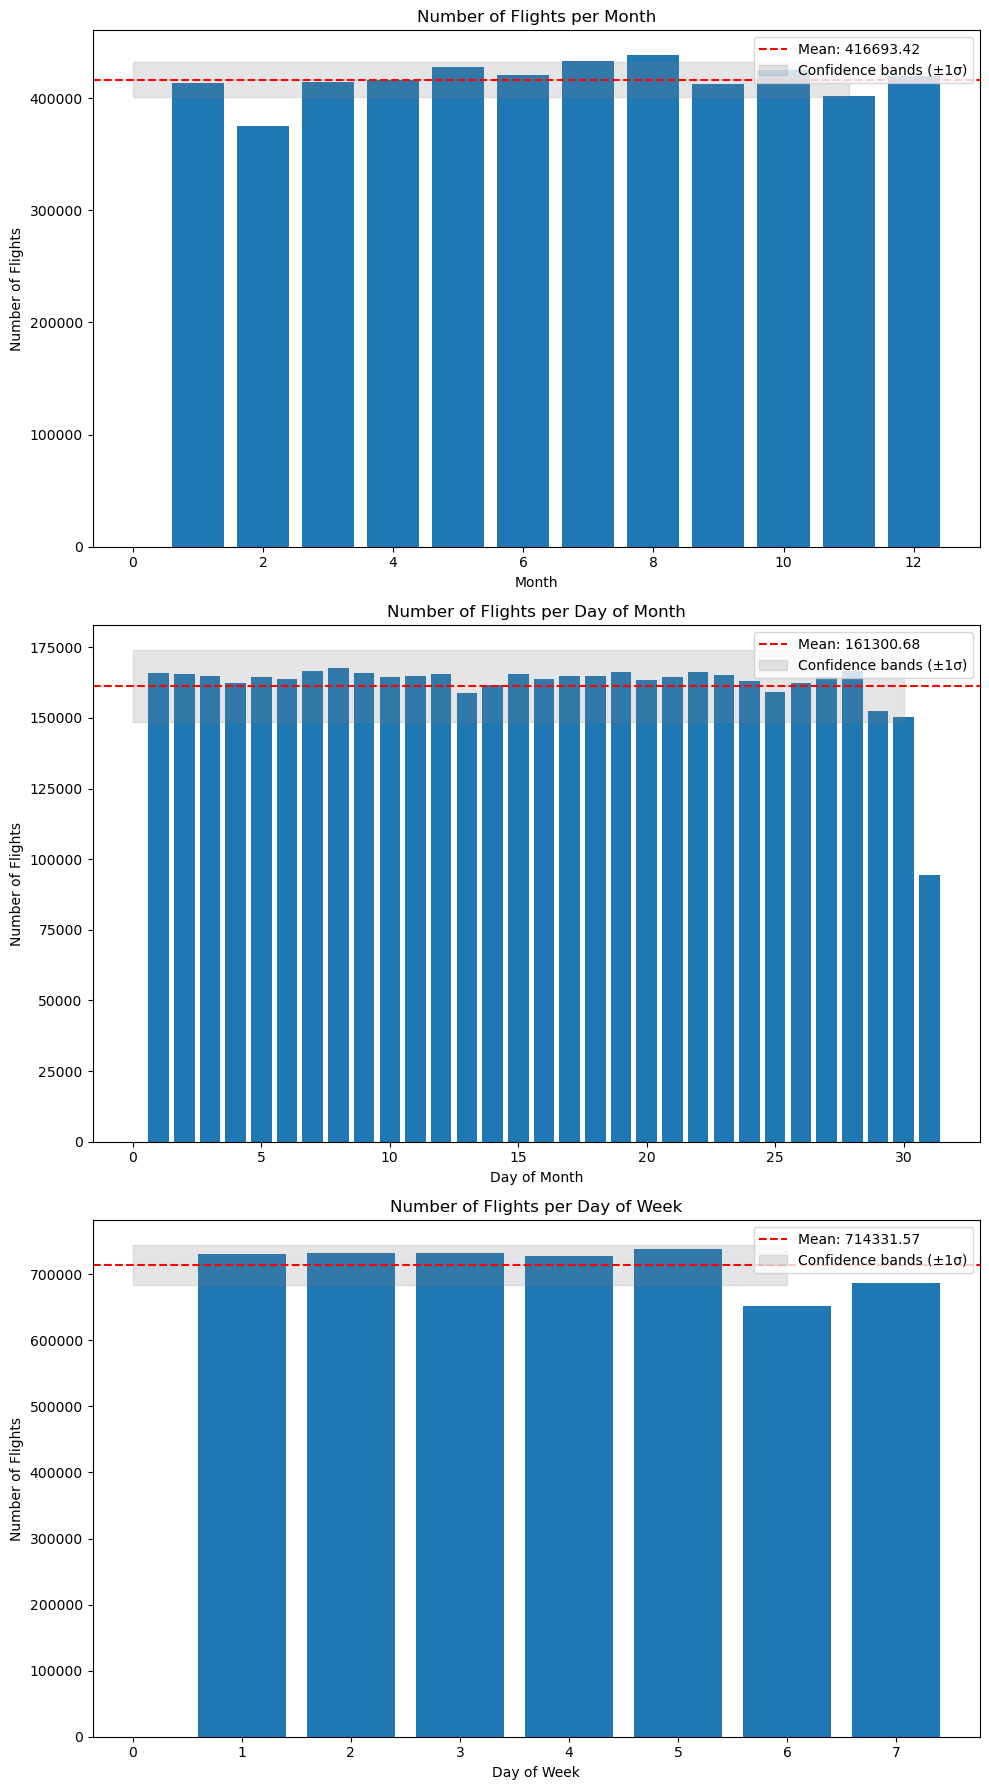

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to add mean and confidence bands to a plot
def add_mean_and_confidence(ax, data_values):
    mean = np.mean(data_values)
    std = np.std(data_values)
    ax.axhline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.fill_between(range(len(data_values)), mean - std, mean + std, color='gray', alpha=0.2, label='Confidence bands (±1σ)')

# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot for Month
month_counts = data['Month'].value_counts().sort_index()
axs[0].bar(month_counts.index, month_counts.values)
add_mean_and_confidence(axs[0], month_counts.values)
axs[0].set_title('Number of Flights per Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Number of Flights')
axs[0].legend()

# Plot for Day of Month
dayofmonth_counts = data['DayofMonth'].value_counts().sort_index()
axs[1].bar(dayofmonth_counts.index, dayofmonth_counts.values)
add_mean_and_confidence(axs[1], dayofmonth_counts.values)
axs[1].set_title('Number of Flights per Day of Month')
axs[1].set_xlabel('Day of Month')
axs[1].set_ylabel('Number of Flights')
axs[1].legend()

# Plot for Day of Week
dayofweek_counts = data['DayOfWeek'].value_counts().sort_index()
axs[2].bar(dayofweek_counts.index, dayofweek_counts.values)
add_mean_and_confidence(axs[2], dayofweek_counts.values)
axs[2].set_title('Number of Flights per Day of Week')
axs[2].set_xlabel('Day of Week')
axs[2].set_ylabel('Number of Flights')
axs[2].legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


### Target variable study
We observe that the data is evenly distributed across all months, days of the month, and days of the week. The main differences arise in months with fewer days and during weekends. Next, we will examine the distribution of the target variable, `ArrDelay`.

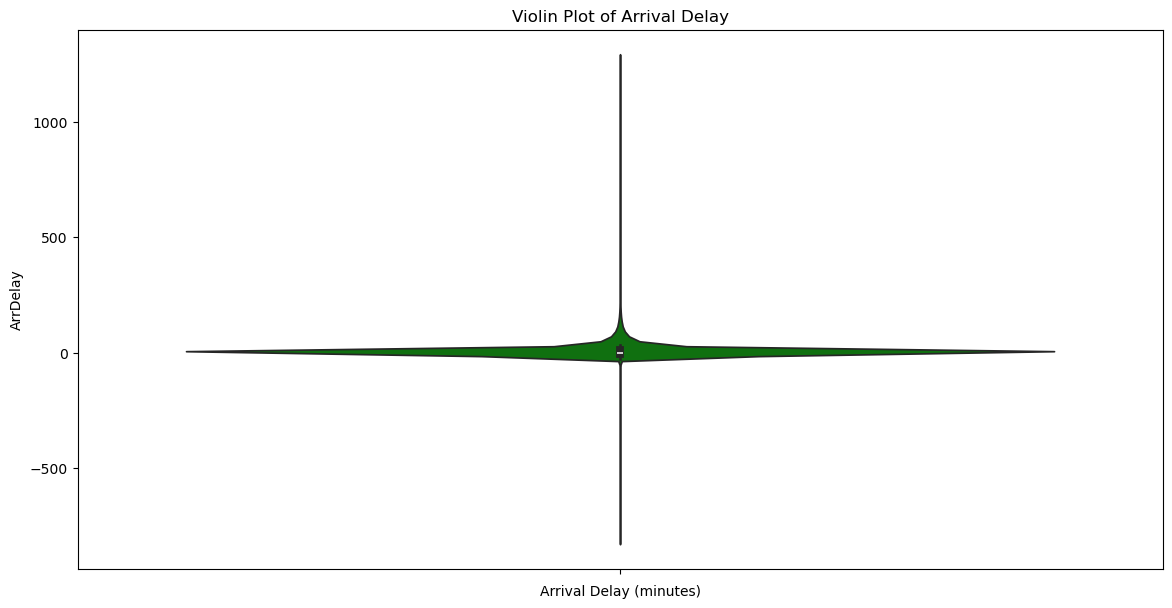

d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
d:\Program Files\Anaconda\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1019: RuntimeWarning: invalid value encountered in scalar divide
  result = sqr.sum(axis=axis, dtype=np.float64) / d


count    5000321.0
mean           NaN
std            NaN
min         -829.0
25%           -6.0
50%            0.0
75%            9.0
max         1291.0
Name: ArrDelay, dtype: float64

In [21]:
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# Violin plot
plt.figure(figsize=(14, 7))
sns.violinplot(y=data['ArrDelay'], color='green')
plt.title('Violin Plot of Arrival Delay')
plt.xlabel('Arrival Delay (minutes)')
plt.show()
data['ArrDelay'].describe()

The minimum delay is -829 minutes, or roughly 13 hours. While such a long delay is possible, a flight cannot arrive this far ahead of schedule. This is likely a data entry error. To address this issue, we remove all observations where `ArrDelay` is less than -120. On the other hand, extreme positive values  cannot be just excluded, as they may represent actual significant delays, unlike the case with extreme negative values.

Now we must decide what to do with the extreme positive values. First, we can calculate how many of the observations are considered extreme based on the violin plot, using 400 minutes as the boundary.

In [22]:
data = data[data['ArrDelay'] >= -120]
data[data['ArrDelay'] > 300].shape[0]/data.shape[0]*100

0.026958328583627816

Extreme values over 300 account for less than 0.03% of the data. Given their potential to significantly affect the models, and considering how few they represent, we have decided to eliminate them from the analysis, resulting in the following final distribution of the target variable.

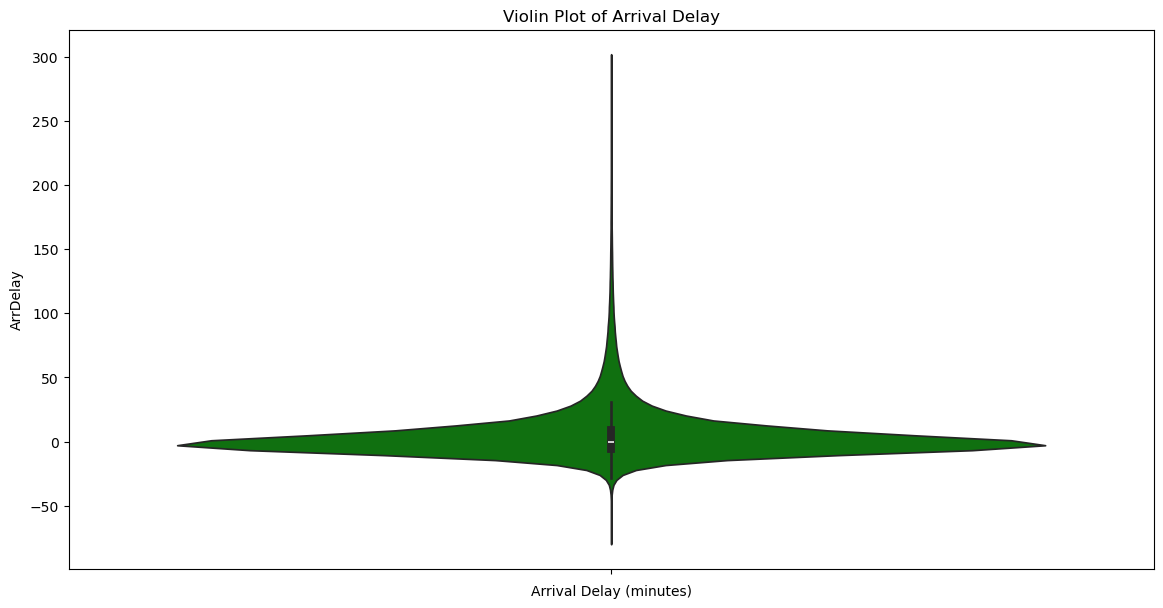

d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
d:\Program Files\Anaconda\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
d:\Program Files\Anaconda\Lib\site-packages\pandas\core\nanops.py:1019: RuntimeWarning: invalid value encountered in scalar divide
  result = sqr.sum(axis=axis, dtype=np.float64) / d


count    4998962.0
mean           NaN
std            NaN
min          -78.0
25%           -6.0
50%            0.0
75%            9.0
max          300.0
Name: ArrDelay, dtype: float64

In [23]:
data = data[data['ArrDelay'] <= 300]
plt.figure(figsize=(14, 7))
sns.violinplot(y=data['ArrDelay'], color='green')
plt.title('Violin Plot of Arrival Delay')
plt.xlabel('Arrival Delay (minutes)')
plt.show()
data['ArrDelay'].describe()


Now we can study the association between the target variable and the other variables studied. We can plot the average delays for each of the variables created to see if there is a higher chance of a delay in a weekend, or in a specific period of the day. 

C:\Users\nacho\AppData\Local\Temp\ipykernel_11808\683857256.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delays = data.groupby(['IsWeekend', 'Season', 'IsMorningFlight', 'IsAfternoonFlight', 'IsEveningFlight', 'IsNightFlight'])['ArrDelay'].mean().reset_index()


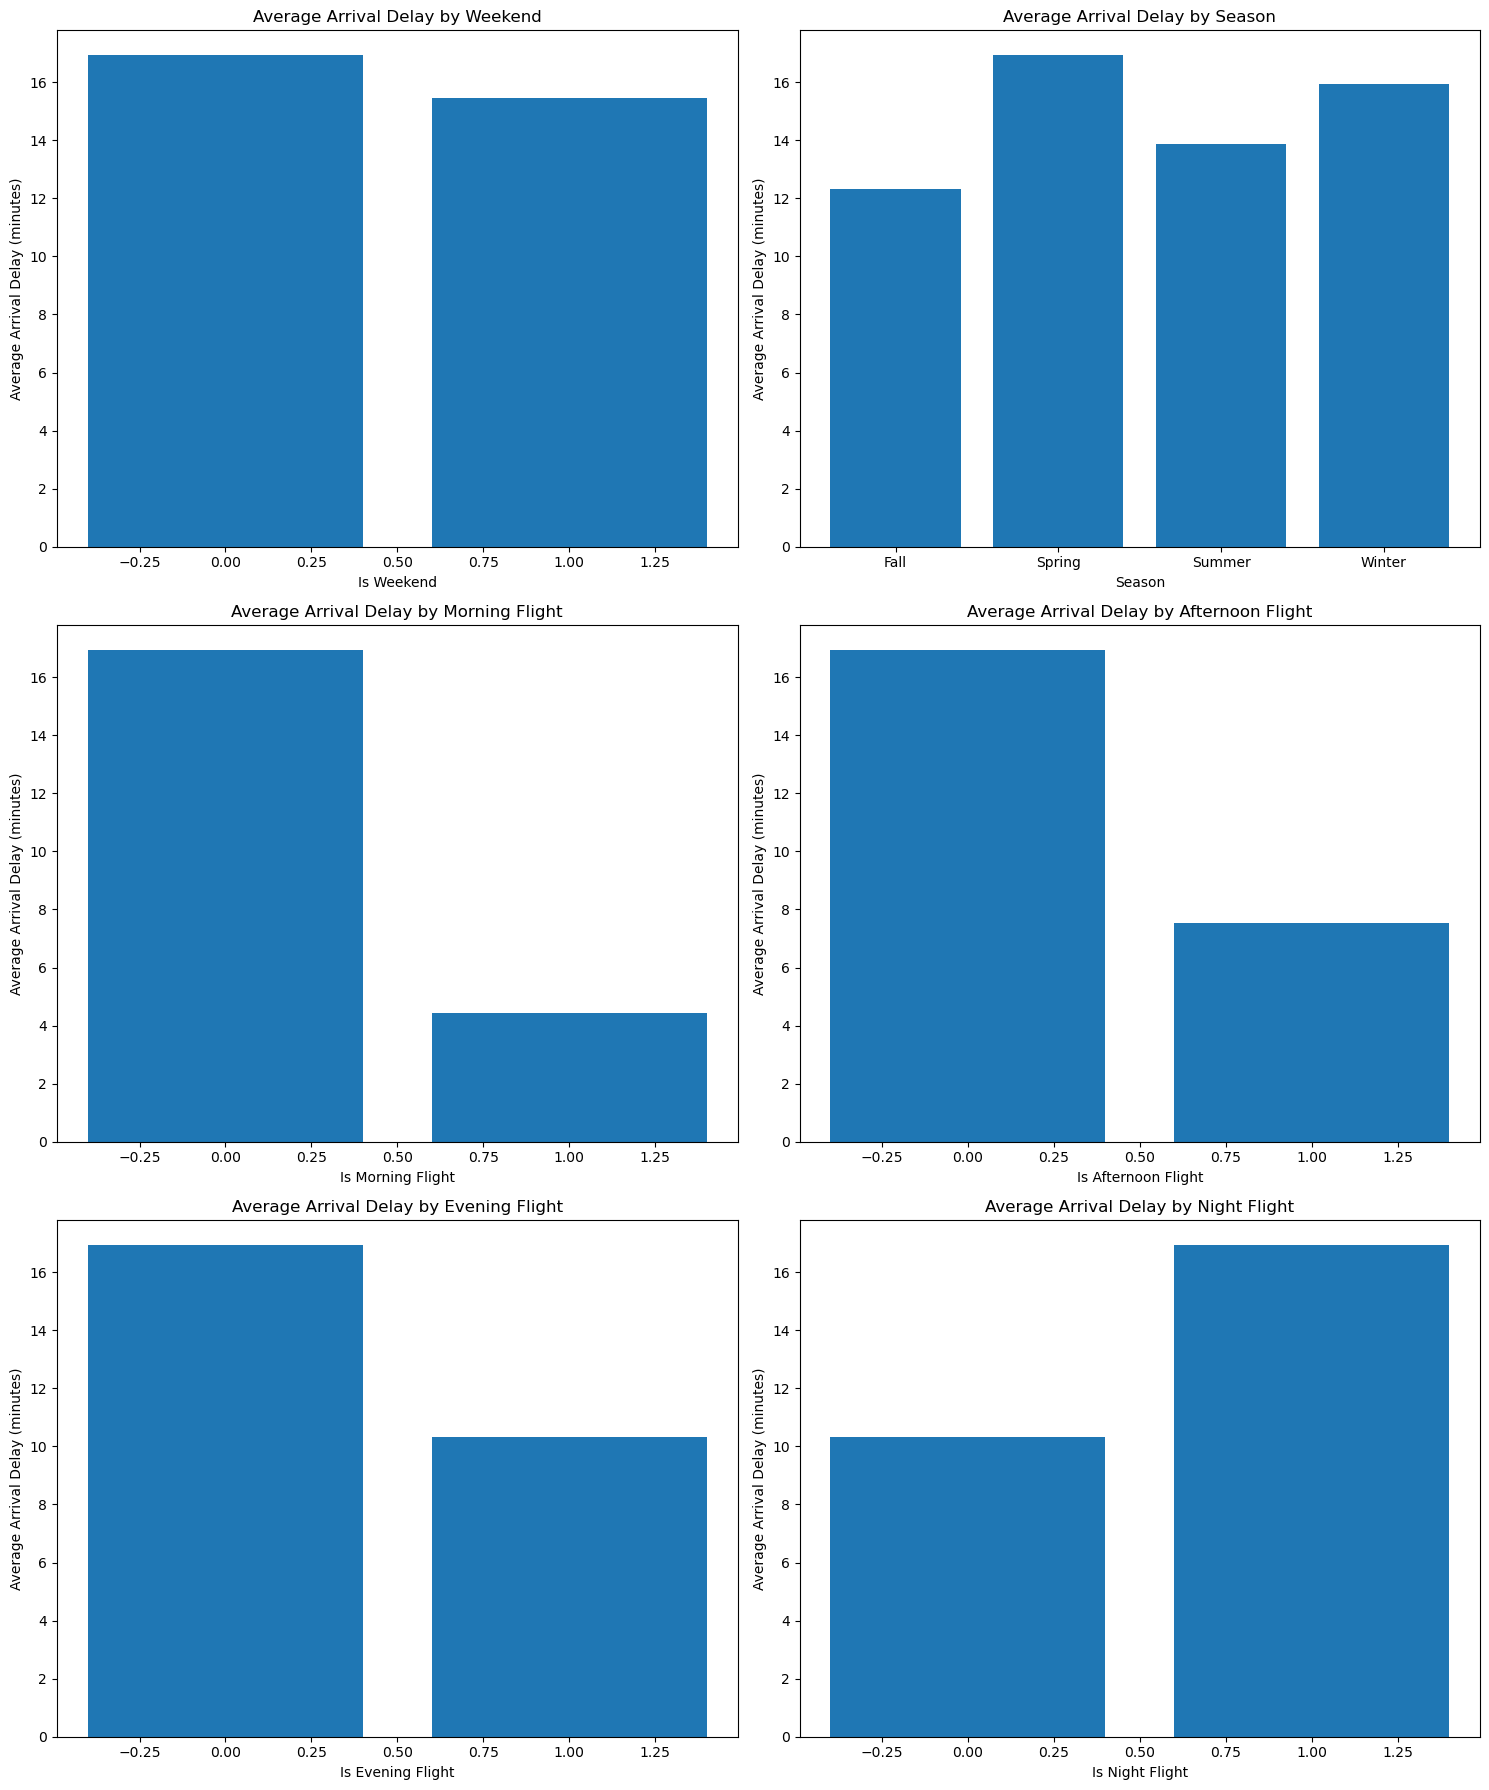

In [24]:
import matplotlib.pyplot as plt

avg_delays = data.groupby(['IsWeekend', 'Season', 'IsMorningFlight', 'IsAfternoonFlight', 'IsEveningFlight', 'IsNightFlight'])['ArrDelay'].mean().reset_index()


fig, axs = plt.subplots(3, 2, figsize=(15, 18))


axs[0, 0].bar(avg_delays['IsWeekend'], avg_delays['ArrDelay'])
axs[0, 0].set_title('Average Arrival Delay by Weekend')
axs[0, 0].set_xlabel('Is Weekend')
axs[0, 0].set_ylabel('Average Arrival Delay (minutes)')


axs[0, 1].bar(avg_delays['Season'], avg_delays['ArrDelay'])
axs[0, 1].set_title('Average Arrival Delay by Season')
axs[0, 1].set_xlabel('Season')
axs[0, 1].set_ylabel('Average Arrival Delay (minutes)')


axs[1, 0].bar(avg_delays['IsMorningFlight'], avg_delays['ArrDelay'])
axs[1, 0].set_title('Average Arrival Delay by Morning Flight')
axs[1, 0].set_xlabel('Is Morning Flight')
axs[1, 0].set_ylabel('Average Arrival Delay (minutes)')


axs[1, 1].bar(avg_delays['IsAfternoonFlight'], avg_delays['ArrDelay'])
axs[1, 1].set_title('Average Arrival Delay by Afternoon Flight')
axs[1, 1].set_xlabel('Is Afternoon Flight')
axs[1, 1].set_ylabel('Average Arrival Delay (minutes)')


axs[2, 0].bar(avg_delays['IsEveningFlight'], avg_delays['ArrDelay'])
axs[2, 0].set_title('Average Arrival Delay by Evening Flight')
axs[2, 0].set_xlabel('Is Evening Flight')
axs[2, 0].set_ylabel('Average Arrival Delay (minutes)')


axs[2, 1].bar(avg_delays['IsNightFlight'], avg_delays['ArrDelay'])
axs[2, 1].set_title('Average Arrival Delay by Night Flight')
axs[2, 1].set_xlabel('Is Night Flight')
axs[2, 1].set_ylabel('Average Arrival Delay (minutes)')


plt.tight_layout()
plt.show()


From this analysis, we can conclude there is a higher tendency of longer delays at night and in spring and winter. 

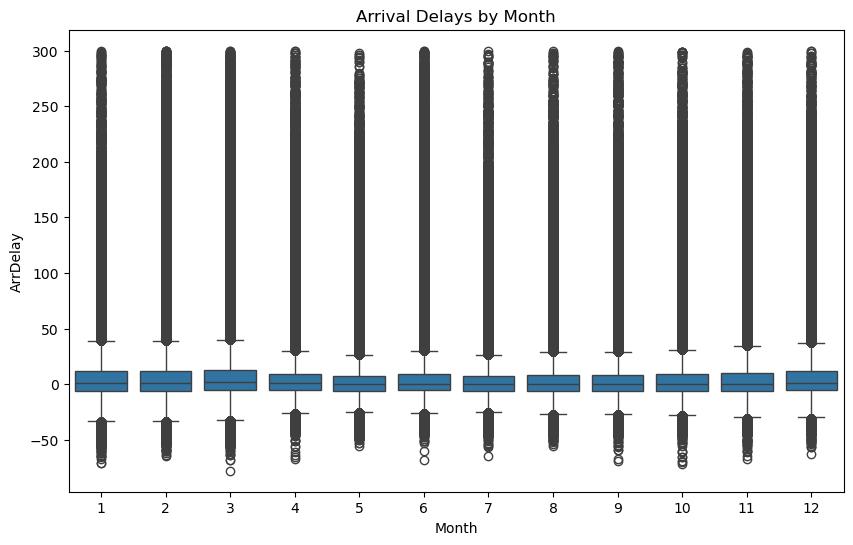

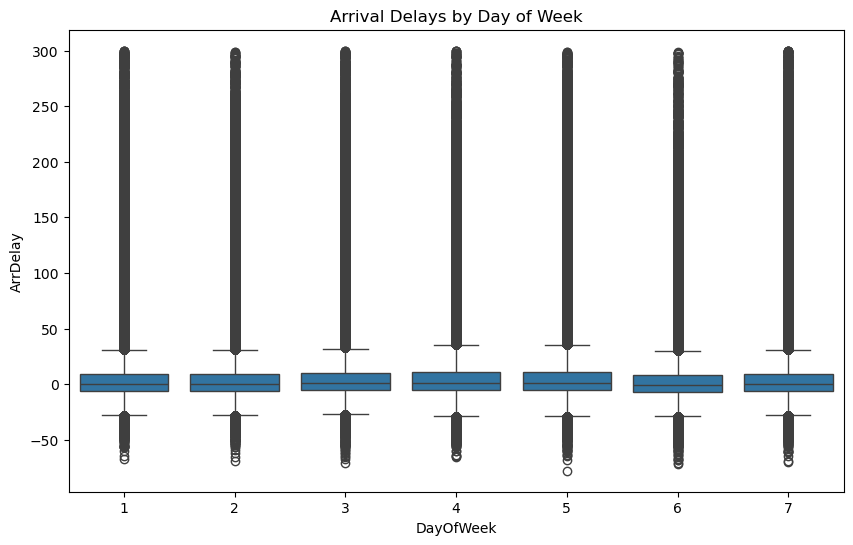

Monthly Kruskal-Wallis: 26469.946074295327 0.0
Day of Week Kruskal-Wallis: 22724.127406927346 0.0


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Monthly patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='ArrDelay', data=data)
plt.title('Arrival Delays by Month')
plt.show()

# Day of week patterns 
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=data)
plt.title('Arrival Delays by Day of Week')
plt.show()

# Kruskal-Wallis tests
# Monthly differences
month_groups = [group for _, group in data.groupby('Month')['ArrDelay']]
h_stat, p_val = stats.kruskal(*month_groups)
print('Monthly Kruskal-Wallis:', h_stat, p_val)

# Day of week differences
dow_groups = [group for _, group in data.groupby('DayOfWeek')['ArrDelay']]
h_stat, p_val = stats.kruskal(*dow_groups)
print('Day of Week Kruskal-Wallis:', h_stat, p_val)


There is statistical diference between the month and the dat of the week. This strongly implies that using this variables as predictors will be beneficial for the prediction of the outcome. 

## Further Data Preprocessing
Using Pyspark methods, the 2007.csv dataset will be cleaned and extracted and stored as an efficient parquet file for model use 
If desired, this part can also be ran as a standalone file with model_preprocesing.py

### Initialization of Spark Session as well as ingestion of CSVs

In [ ]:
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

from pyspark.sql.functions import col, lit,concat,udf,coalesce
import pandas as pd

spark = SparkSession \
    .builder \
    .appName("Machine Learning") \
    .config('spark.executor.memory', '8g') \
    .config('spark.driver.memory', '8g') \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config('spark.executor.cores', '4')  \
    .config('spark.executor.instances', '4') \
    .config('spark.sql.shuffle.partitions', '400')  \
    .config('spark.memory.fraction', '0.8') \
    .config('spark.memory.storageFraction', '0.5') \
    .config('spark.dynamicAllocation.enabled', 'true')  \
    .config('spark.dynamicAllocation.minExecutors', '1') \
    .config('spark.dynamicAllocation.maxExecutors', '10') \
    .config('spark.dynamicAllocation.initialExecutors', '2') \
    .config('spark.executor.memoryOverhead', '4g') \
    .getOrCreate()





## Load Main CSV file as well as supporting dataset plane-data.csv
dataFrame = spark.read.format("csv").option("inferschema","true").option("header", "true").load("data/2007.csv")

## Load Airplane age and model type as well as first service date
airplaneInfo= spark.read.format("csv").option("inferschema","true").option("header", "true").load("data/plane-data.csv")

## Remove rows with NAs
airplaneInfo=airplaneInfo.dropna()

#Perform inner join on plane info dataset
dataFrame=dataFrame.join(airplaneInfo,on=['TailNum'],how='inner')



From here, certain columns will be cast to their proper datatype, a several new columns will be generated and null values will be replaced with 0 

In [ ]:
## Cast certain columns to proper integer datatype
dataFrame=dataFrame.withColumn('CRSElapsedTime',dataFrame['CRSElapsedTime'].cast("double"))
dataFrame=dataFrame.withColumn('DepDelay',dataFrame['DepDelay'].cast("double"))
dataFrame=dataFrame.withColumn('TaxiOut',dataFrame['TaxiOut'].cast("double"))
dataFrame=dataFrame.withColumn('Distance',dataFrame['Distance'].cast("double"))
dataFrame=dataFrame.withColumn('ArrDelay',dataFrame.ArrDelay.cast("double"))
dataFrame=dataFrame.withColumn('DepTime',dataFrame['DepTime'].cast("integer"))
dataFrame=dataFrame.withColumn('CRSDepTime',dataFrame['CRSDepTime'].cast("integer"))
dataFrame=dataFrame.withColumn('CRSArrTime',dataFrame['CRSArrTime'].cast("integer"))
dataFrame=dataFrame.withColumn('PlaneYear',dataFrame['PlaneYear'].cast("integer"))
dataFrame=dataFrame.withColumn('ArrDelay',dataFrame['ArrDelay'].cast("double"))


## Infer Plane age in years 
dataFrame=dataFrame.withColumn("PlaneAgeYears",col("Year")-col("PlaneYear"))



## Replace any null values with 0
dataFrame = dataFrame.fillna(0)


## Reformat DepTime 
dataFrame=dataFrame.withColumn("DepTimeMinutes",col("DepTime")%100)
dataFrame=dataFrame.withColumn("DepTimeHour",60*col("DepTime")/100)

## Cast to integer
dataFrame=dataFrame.withColumn("DepTimeHour",dataFrame["DepTimeHour"].cast("int"))

## Add columns together to get total minutes
dataFrame=dataFrame.withColumn("DepTimeMinutesSinceMidnight",dataFrame["DepTimeHour"]+dataFrame["DepTimeMinutes"])


## Reformat CRSDepTime
dataFrame=dataFrame.withColumn("CRSDepTimeMinutes",col("CRSDepTime")%100)
dataFrame=dataFrame.withColumn("CRSDepTimeHour",60*col("CRSDepTime")/100)

## Cast to integer 
dataFrame=dataFrame.withColumn("CRSDepTimeHour",dataFrame["CRSDepTimeHour"].cast("int"))


## Add columns together to get total  minutes
dataFrame=dataFrame.withColumn("CRSDepTimeMinutesSinceMidnight",dataFrame['CRSDepTimeMinutes']+dataFrame['CRSDepTimeHour'])


## Apply a filter to ArrDelay to remove extreme outliers
dataFrame=dataFrame.filter((col('ArrDelay') > -120) & (col('ArrDelay') < 300))



## Filtering out forbidden columns and get rid of exceptional flights (cancelled or diverted)

## For now, dataFrameYear will also be excluded dataFrame['Year'], dataFrame['FlightNum'], dataFrame['TailNum']


## Remove cancelled and diverted flights
dataFrame=dataFrame.select(dataFrame['Month'],dataFrame['DayOfMonth'],dataFrame['DayOfWeek'], dataFrame['Origin'],
                           dataFrame['DepTimeMinutesSinceMidnight'], dataFrame['CRSDepTimeMinutesSinceMidnight'],
                           dataFrame['CRSDepTimeHour'],dataFrame['CRSArrTime'],dataFrame['PlaneModel'],dataFrame['PlaneEngineType'],dataFrame['PlaneAgeYears'],
                           dataFrame['UniqueCarrier'],dataFrame['CRSElapsedTime'], dataFrame['DepDelay'],
                           dataFrame['Distance'],dataFrame['TaxiOut'],dataFrame['ArrDelay']).filter((dataFrame['Cancelled']!=1) & (dataFrame['Diverted']!=1))



From here, more specific ML preprocessing will be applied to certain variables such as scaling, as well as using a string indexer for categorical variables. Notably, the mapping files generated will also be saved for further use by app.py so the prope values are mapped to the proper indexes

In [ ]:

## Start ML-specific Preprocessing

from pyspark.ml.regression import DecisionTreeRegressor,GBTRegressor,RandomForestRegressor,LinearRegression
from pyspark.ml.feature import VectorIndexer,VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer


## Scale Distance value
assembler = VectorAssembler(inputCols=["Distance"], outputCol="DistanceVec")
dataFrame = assembler.transform(dataFrame)

from pyspark.ml.feature import StandardScaler

## Define scaling
scaler = StandardScaler(inputCol="DistanceVec", outputCol="DistanceScaled",
                        withStd=True, withMean=False)

## Fit scaler to dataset
scaler_model = scaler.fit(dataFrame)

## Apply scaler
dataFrame = scaler_model.transform(dataFrame)



## Scale Time Variables (DepTime)
assembler = VectorAssembler(inputCols=["DepTimeMinutesSinceMidnight"], outputCol="DepTimeMinutesSinceMidnightVec")
dataFrame = assembler.transform(dataFrame)


scaler = StandardScaler(inputCol="DepTimeMinutesSinceMidnightVec", outputCol="DepTimeMinutesSinceMidnightScaled",
                        withStd=True, withMean=False)


scaler_model = scaler.fit(dataFrame)

dataFrame = scaler_model.transform(dataFrame)





## Scale Time Variables (CRSDepTime)
assembler = VectorAssembler(inputCols=["CRSDepTimeMinutesSinceMidnight"], outputCol="CRSDepTimeMinutesSinceMidnightVec")
dataFrame = assembler.transform(dataFrame)


scaler = StandardScaler(inputCol="CRSDepTimeMinutesSinceMidnightVec", outputCol="CRSDepTimeMinutesSinceMidnightScaled",
                        withStd=True, withMean=False)


scaler_model = scaler.fit(dataFrame)

dataFrame = scaler_model.transform(dataFrame)




## Scale Time Variables (CRSElapsedTime)
assembler = VectorAssembler(inputCols=["CRSElapsedTime"], outputCol="CRSElapsedTimeVec")
dataFrame = assembler.transform(dataFrame)


scaler = StandardScaler(inputCol="CRSElapsedTimeVec", outputCol="CRSElapsedTimeScaled",
                        withStd=True, withMean=False)


scaler_model = scaler.fit(dataFrame)

dataFrame = scaler_model.transform(dataFrame)





# Apply indexing to categorical columns Origin, UniqueCarrier, PlaneModel


for categorical_variable in ['Origin','UniqueCarrier','PlaneModel']:
    indexer=StringIndexer(inputCol=categorical_variable, outputCol=categorical_variable+"Index")
    indexer_model = indexer.fit(dataFrame)
    
    dataFrame=indexer_model.transform(dataFrame)

    # Save the mapping
    labels = indexer_model.labels  # List of original strings
    
    labels_df=pd.DataFrame(labels)

    labels_df.columns=['label']

    labels_df['index']=labels_df.index
    ## To be used in app.py later on
    labels_df.to_csv('mappings/'+categorical_variable+'_mapping.csv',index=False)


Finally, one last section of code is ran to remove any unnecessary columns as well as convert a set of features to an array (to be used by the models). The data is saved to a parquet file

In [ ]:
## Reduce junk columns 
selected_cols=['Month', 'DayOfMonth', 'DayOfWeek', 'OriginIndex', 'DepTimeMinutesSinceMidnightScaled', "PlaneAgeYears","PlaneModelIndex",
                             'CRSDepTimeMinutesSinceMidnightScaled','CRSArrTime', 'UniqueCarrierIndex', 'CRSElapsedTimeScaled', 
                             'DepDelay', 'DistanceScaled', 'TaxiOut','ArrDelay']

dataFrame=dataFrame.select(selected_cols)


vecAssembler=VectorAssembler(inputCols=['Month', 'DayOfMonth', 'DayOfWeek', 'OriginIndex', 'DepTimeMinutesSinceMidnightScaled',"PlaneAgeYears","PlaneModelIndex",
                             'CRSDepTimeMinutesSinceMidnightScaled','CRSArrTime', 'UniqueCarrierIndex', 'CRSElapsedTimeScaled', 
                             'DepDelay', 'DistanceScaled', 'TaxiOut'],outputCol="features")


output = vecAssembler.transform(dataFrame)

output.write.mode("overwrite").parquet("data_cleaned.parquet")
## End spark session
spark.stop()
print("success")

## Model Building and Evaluation
Now with the data_cleaned.parquet file, the models will be constructed and saved, and the code will also decide the best model to save to the best_model path. This code can also be run separately (it needs the data.parquet file as an input) using models.py

In [ ]:
## Reinitialize Spark session
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

from pyspark.sql.functions import col, lit,concat,udf,coalesce


spark = SparkSession \
    .builder \
    .appName("Machine Learning") \
    .config('spark.executor.memory', '8g') \
    .config('spark.driver.memory', '8g') \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config('spark.executor.cores', '4')  \
    .config('spark.executor.instances', '4') \
    .config('spark.sql.shuffle.partitions', '400')  \
    .config('spark.memory.fraction', '0.8') \
    .config('spark.memory.storageFraction', '0.5') \
    .config('spark.dynamicAllocation.enabled', 'true')  \
    .config('spark.dynamicAllocation.minExecutors', '1') \
    .config('spark.dynamicAllocation.maxExecutors', '10') \
    .config('spark.dynamicAllocation.initialExecutors', '2') \
    .config('spark.executor.memoryOverhead', '4g') \
    .getOrCreate()

from pyspark.ml.regression import DecisionTreeRegressor,GBTRegressor,RandomForestRegressor,LinearRegression
from pyspark.ml.feature import VectorIndexer,VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.feature import StandardScaler

## Load saved dataframe
dataFrame = spark.read.parquet("data_cleaned.parquet")

The model will be split into a training test split, a dictionary is defined to set up each model and some key variables for identifying the best model will be initialized

In [ ]:

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = dataFrame.randomSplit([0.8, 0.2],seed=42)

# trainingData.show()

## To be used in iteration through different models 

model_options={"LinearRegression":LinearRegression(featuresCol="features",labelCol="ArrDelay"),
                "DecisionTreeRegressor":DecisionTreeRegressor(featuresCol="features",labelCol="ArrDelay"),
                "GBTRegressor":GBTRegressor(featuresCol="features",labelCol="ArrDelay"),
                "RandomForestRegressor":RandomForestRegressor(featuresCol="features",labelCol="ArrDelay")
                
}

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Variables para guardar el mejor modelo
best_model = None
best_model_name = None
best_rmse = float("inf")

Now, the key part of the code will be executed. A grid search is conducted for each model type, and the model will calculate key metrics such as RMSE to establish which model is the best. All results are saved to a results.txt file (append), and the spark session will be terminated

In [ ]:

## Iterate through different models 

for a_model in model_options.keys():

    # Train Model
    model = model_options[a_model]

    
    if a_model=="LinearRegression":
        paramGrid = ParamGridBuilder() \
        .addGrid(model.regParam, [0.01, 0.1, 1.0]) \
        .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()

    elif a_model=="GBTRegressor":
        paramGrid = ParamGridBuilder() \
        .addGrid(model.maxDepth, [3, 5, 7]) \
        .addGrid(model.maxBins, [300, 400]) .build()
        # .addGrid(model.stepSize, [0.01, 0.1, 0.2]) \
        # .addGrid(model.maxIter, [50, 100]) \

    elif a_model=="RandomForestRegressor":
        paramGrid = ParamGridBuilder() \
        .addGrid(model.maxDepth, [3, 5, 10]) \
        .addGrid(model.numTrees, [50, 100, 200]) \
        .addGrid(model.maxBins, [300,400]) \
        .build()
        # .addGrid(model.subsamplingRate, [0.7, 1.0]) \
        # .addGrid(model.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    
    elif a_model=="DecisionTreeRegressor":
        paramGrid = ParamGridBuilder() \
        .addGrid(model.maxDepth, [3, 5, 10]) \
        .addGrid(model.maxBins, [300,400]) \
        .build()
        # .addGrid(model.minInstancesPerNode, [10]) \
        # .addGrid(model.minInfoGain, [0.0, 0.01, 0.05]) \
    
  


    # Evaluate Model

    evaluator=RegressionEvaluator(metricName="rmse",labelCol="ArrDelay",predictionCol="prediction")

    crossval = CrossValidator(estimator=model,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
           numFolds=5)  
    
    cvModel = crossval.fit(trainingData)



    # Realizar predicciones usando el modelo ajustado
    bestModel = cvModel.bestModel
    predictions = bestModel.transform(testData)

    print(f"BestModel type: {type(bestModel)}")
    test_predictions = bestModel.transform(testData)
    rmse = evaluator.evaluate(test_predictions)

    # Evaluar el modelo
    rmse = evaluator.evaluate(predictions)

    # Comparar con el mejor modelo actual
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = bestModel
        best_model_name = a_model

    # Guardar el mejor modelo
if best_model is not None:
    # Guardar el modelo ajustado
    bestModel.write().overwrite().save(f"best_model/{a_model}")

    with open('results.txt','a') as f:
        f.write(a_model+f" Root Mean Squared Error (RMSE) on test data: {best_rmse}+\n")

spark.stop()